In [5]:
import math 
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline 

In [6]:
def func(x):
    return 3*x**2 - 4*x + 5  

In [7]:
print(func(10))

265


[-5.   -4.75 -4.5  -4.25 -4.   -3.75 -3.5  -3.25 -3.   -2.75 -2.5  -2.25
 -2.   -1.75 -1.5  -1.25 -1.   -0.75 -0.5  -0.25  0.    0.25  0.5   0.75
  1.    1.25  1.5   1.75  2.    2.25  2.5   2.75  3.    3.25  3.5   3.75
  4.    4.25  4.5   4.75]


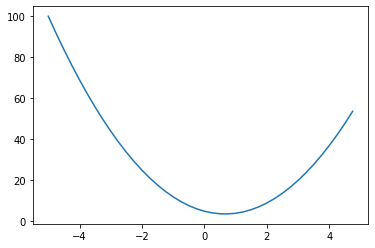

In [8]:
xs = np.arange(-5,5,0.25)   
print(xs) 
ys = func(xs) 
plt.plot(xs,ys) 

ok so what is a derrivative ?  
a function is said to be defferintiable on a if a in its domain and the limit as h goes to 0 to the function f(a+h) - f(a) all over h  
and what this means is that if we are on x or a if we increased by some h what is the slope at this point , doest go down or up and by how much 
what is the respond of the function at x or a when we slightly increase the a by a small h .  

In [9]:
h = 0.000000001   
x = 3   
x2 = -3 
x3 = 2/3 
#calculatuing the derivative of the function 
deriv = (func(x+h) - func(x))/h 
deriv2 = (func(x2+h) - func(x2))/h 
deriv3 = (func(x3+h) - func(x3))/h  
print(deriv) 
print(deriv2) 
print(deriv3) 


14.000001158365194
-22.000001820288162
0.0


u can see that when we got the 2/3 derrivative we say that the function is not responding to any change , then the derrivative is 0 .  
track the points and then we see how the slope is doing when we plot the tangent 

In [10]:
#more cmplex function 
a = 2 
b = -3 
c = 10 
y = a*b+c  
y 

4

In [11]:
h = 0.0001   
y = a*b+c  
a+=h 
y2 = a*b+c 
print(f"the y1 is %f and the y2 is %f" %(y,y2)) 
deriv = (y2-y)/h  
print(f"the derivative is %f" %(deriv))  



the y1 is 4.000000 and the y2 is 3.999700
the derivative is -3.000000


u can see that we are intuitively exploring , the derrivative 
so if we bumbed up the value of a  
we will have as derrivative with respect to a the value of b + 0  =  -3 roughly 
and if we messed up with b little bit we will have a  
and for c we will have just 1 

In [12]:
a  = 2 
b = -3 
c = 10 
y = a*b+c 
h = 0.0001 
c += h 
derrivative = (a*b+c - y)/h  
print(f"the derivative is %f" %(derrivative))

the derivative is 1.000000


we need to move to neural networks , which will realy need some big objects to hold 


In [30]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [16]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

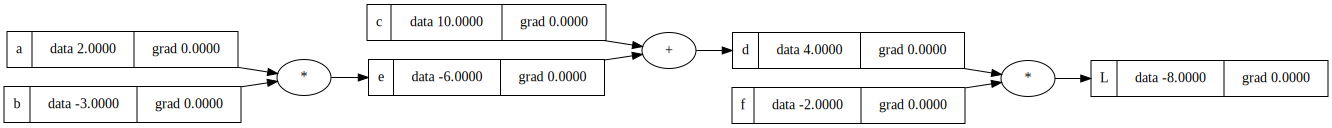

In [17]:
draw_dot(L)


finding the gradients :  
so basically what we are doing here is we want to calc some gradient or the derrivative , of every node wtr to the final output   
ok take the d node for example and the L node 
L = df 
and the dL/dd = f 
back to the def of the derrivative (f(x+h) - f(x))/h  


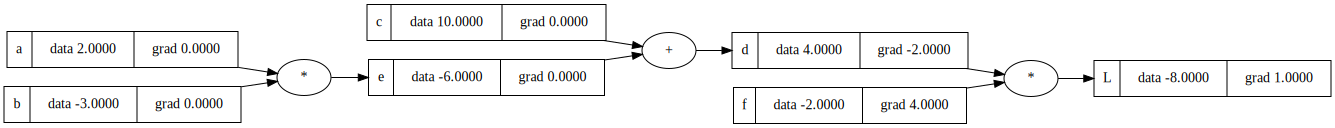

In [18]:
f.grad = 4  
L.grad = 1 
d.grad = -2   
draw_dot(L)


NOW the dL/dc and then we will derive dL/dc we know the derrivative of L with d but c or e ?? we dont how e and c impact L 
so what is dd/dc   
d = c +e   
dd/dc = 1    
f(x+h)-f(x) / h as h goes to 0 
focus on c and its effect of d 
c+h + e - c - e    /  h 
so h/h so 1 
yes that good but how we got the dL/de or dL/dc its embedded 
so chain  rule is good here 
if a variable z depends on y and (so that z and why are dependent) , and y depends on x (so that y and x are dependent) then z depends on x through the intermediate variable y  
and the derrivative of z wrt x is dz/dy*dy/dx   

we want dl/dc and we know the dd/dc and we know the dl/dd so the dl/dc  = dl/dd * dd/dc   
so what we need to figure out is that the dL/dc  -2*(1) and  dL/de is also a -2 

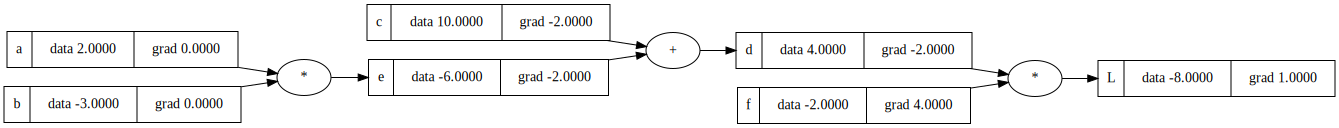

In [19]:
c.grad = -2 
e.grad = -2  
draw_dot(L)

now we need dL/da = de/da * dL/de 
also we need dL/db = de/db *  dL/de  


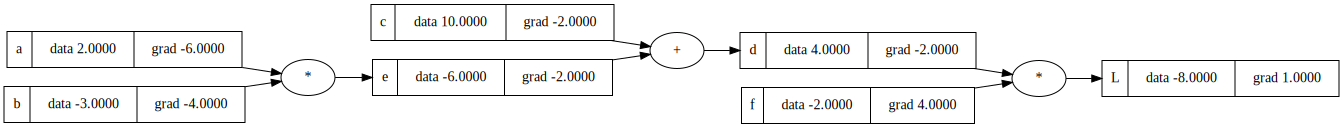

In [20]:
a.grad = -6  
b.grad = -4  
draw_dot(L)

WE WANT TO IMPLEMENT THE BACK PROPAGATIOJN ON SOME NEURONS 


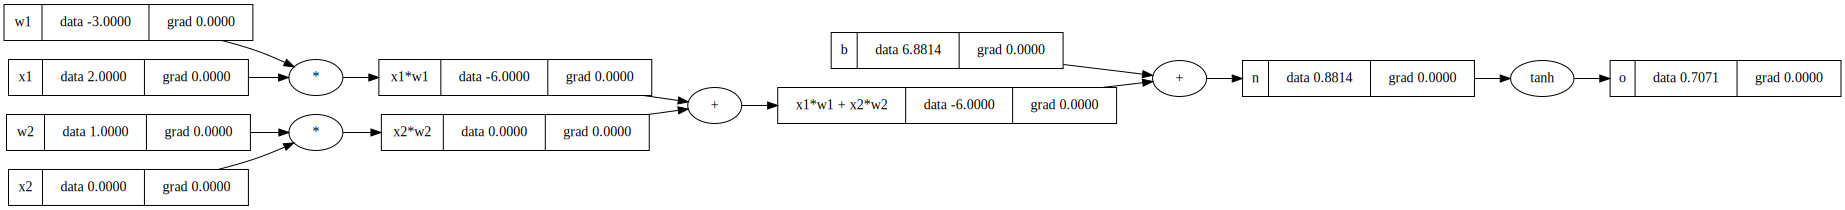

In [26]:
# inputs x1,x2 
import math 
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o' 
draw_dot(o) 

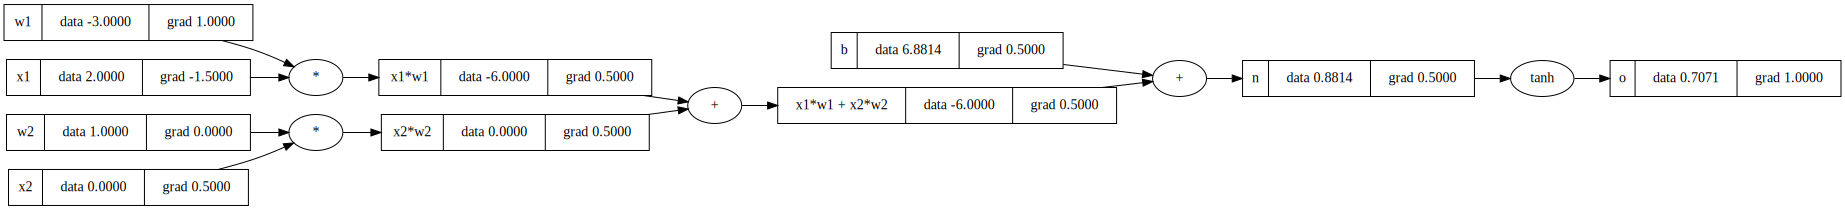

In [27]:
o.backward() 
draw_dot(o) 

assuming that u wan tto do manual propagation 
now we need to fill thos derrivatives here and there , and what really matters is the derrivatives of the weights  
start by the derrivative of n which is a base case of 1    
a note on the derrivatives with tanh says that if we want to compute the derrivative of do/dn and o is a tanh activated n then its derrivative is the 1-tan(n)**2 which is 1-o**2  

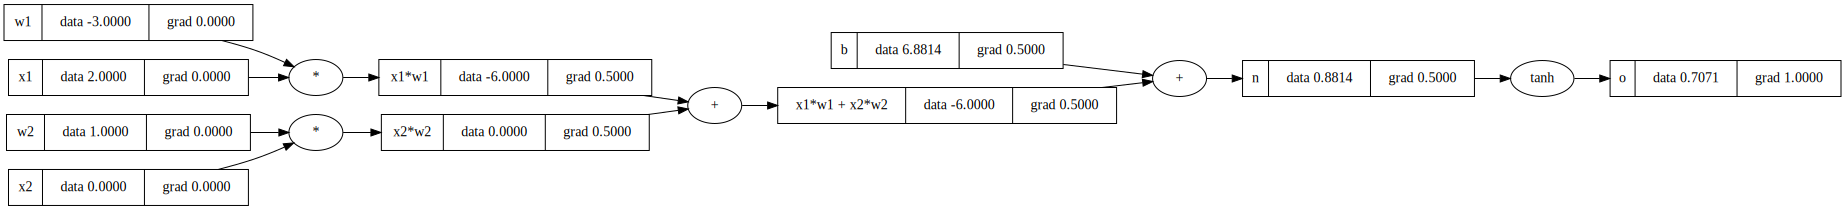

In [22]:
o.grad = 1.0   
o.data  
1 - o.data**2   
n.grad = (1 - o.data**2)   # this is do/dn    
x1w1x2w2.grad = (1 - o.data**2)  
b.grad = (1 - o.data**2)  
x1w1.grad = (1 - o.data**2) 
x2w2.grad = (1 - o.data**2)   
draw_dot(o) 


so the plus is distributive of that gradient , since if i want to compute the derrivative of do/db , then i want to comopute the derrivative of do/dn and multiply that by the dn/db and remeber that n  is nothing but the summation b and another term idependent of b this will drop in derrivation and we will have only the b term to evaluate to 1  
now we need to get the derrivative of o derrivative with respect to the w1 and to that w2 its a mult operation so we now that the derrivative should be the second term , for w1 its x1 and for w2 its x2 

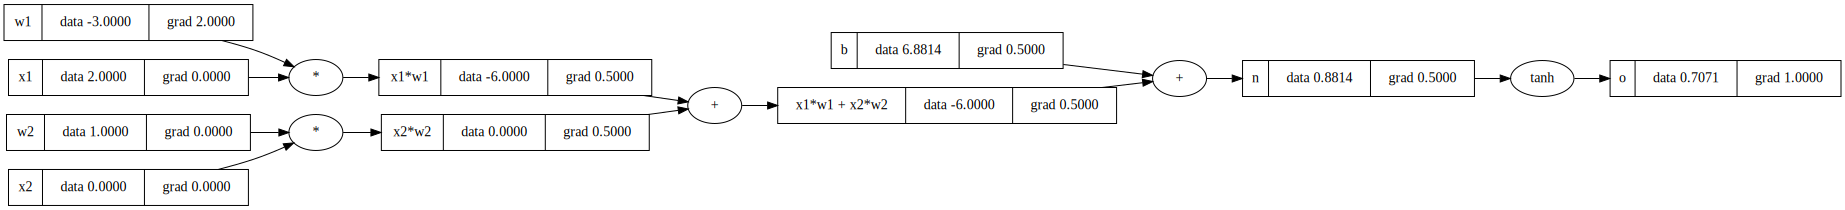

In [23]:
w1.grad = x1.data   
w2.grad = x2.data  
draw_dot(o)

explaining the code of back propagation :  
so first we know that if we are splitting on a +  operation its the out or the main derrivative * 1 simply the other term is dropped to 0 and the term that is identical to the out or the main is the same  
second we know that if we are splitting on a *  operation its the out or the main derrivative times the derrivative of the children wrt the main so its simply the other term in the expression   
in case of tanh its out*1-(tan(self)**2)  or out * 1-out**2 in other simple terms 

introducing topological sort  
its a graph algorithm in which we are sure that after the run all the graph is going from left to right  
so its perform dfs and return the reverse finishing order of a DFS  
T OPOLOGICAL -S ORT .G/
1 call DFS.G/ to compute ﬁnishing times :f for each vertex 
2 as each vertex is ﬁnished, insert it onto the front of a linked list
3 return the linked list of vertices 
OR USE a vector to store the vertices then reverse the given vector  
top sort depends on the idea that  
if G contains an
edge uv then u appears before v in the ordering 
so u are only in the list if all ur children are in the list 

In [24]:
topo = []  
visited = set() 
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v) 
build_topo(o) 
topo 

[Value(data=6.881373587019543),
 Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

note that in the gradient computations we are accumulating and not overriding and thats to handle the case of using the same node twice   
now we will somehow compare with what we use under the hood , pytorch implementation 

In [ ]:
import torch  
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item()) 

tensors are n dim scalars , in a single compact representation 


In [32]:
class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

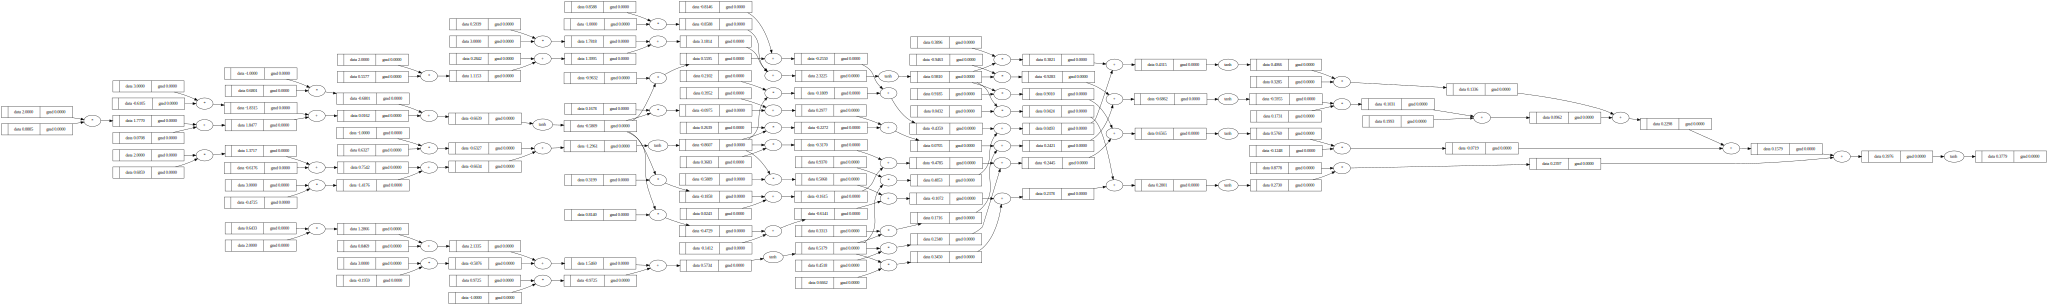

In [33]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x) 
draw_dot(n(x))

In [ ]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets 
for k in range(20):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  
  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad
  
  print(k, loss.data)
  